In [16]:
import numpy as np

def iou(a, b):
    # a,b: (x1,y1,x2,y2)
    x1 = max(a[0], b[0]); y1 = max(a[1], b[1])
    x2 = min(a[2], b[2]); y2 = min(a[3], b[3])
    inter = max(0, x2-x1) * max(0, y2-y1)
    area_a = (a[2]-a[0]) * (a[3]-a[1])
    area_b = (b[2]-b[0]) * (b[3]-b[1])
    union = area_a + area_b - inter + 1e-6
    return inter / union

def box_center(b):
    return np.array([(b[0]+b[2])/2.0, (b[1]+b[3])/2.0], dtype=float)

# Input: dict frame_index -> list of boxes [x1,y1,x2,y2] (optionally with scores)
detections_by_frame = {
    0: [[339, 254, 258, 311], [340, 256, 258, 311]],
    1: [[610, 384, 187, 268], [609, 385, 187, 268]],
}

next_id = 0
tracks = {}  # id -> dict(points=[(frame, cx, cy)], last_box, misses)
IOU_THRESH = 0.3
MAX_MISSES = 10

for f in sorted(detections_by_frame.keys()):
    dets = detections_by_frame[f]
    unmatched_dets = set(range(len(dets)))
    # Try to match each existing track to one detection (greedy by best IoU)
    for tid, t in list(tracks.items()):
        # Drop stale tracks
        if t['misses'] > MAX_MISSES:
            del tracks[tid]
            continue
        # Find best det by IoU
        best_j = -1; best_iou = 0.0
        for j in unmatched_dets:
            i = iou(t['last_box'], dets[j])
            if i > best_iou:
                best_iou, best_j = i, j
        if best_iou >= IOU_THRESH:
            # update track
            c = box_center(dets[best_j])
            t['points'].append((f, float(c[0]), float(c[1])))
            t['last_box'] = dets[best_j]
            t['misses'] = 0
            unmatched_dets.remove(best_j)
        else:
            t['misses'] += 1

    # Any unmatched detections start new tracks
    for j in unmatched_dets:
        c = box_center(dets[j])
        tracks[next_id] = {
            'points': [(f, float(c[0]), float(c[1]))],
            'last_box': dets[j],
            'misses': 0
        }
        next_id += 1

# Optional smoothing (EMA) per track
ALPHA = 0.5
for tid, t in tracks.items():
    if not t['points']: continue
    pts = np.array([[fr, x, y] for fr, x, y in t['points']])
    sm = pts.copy()
    for k in range(1, len(pts)):
        sm[k,1:3] = ALPHA*pts[k,1:3] + (1-ALPHA)*sm[k-1,1:3]
    t['points_smooth'] = [tuple(row) for row in sm.tolist()]

# Result: for each track ID, `points_smooth` is your trajectory [(frame, cx, cy), ...]

# Print smoothed trajectories
for tid, tdata in tracks.items():
    print(f"Track {tid}:")
    for frame, x, y in tdata["points_smooth"]:
        print(f"  frame {frame}: x={x:.1f}, y={y:.1f}")


Track 0:
  frame 0.0: x=298.5, y=282.5
Track 1:
  frame 0.0: x=299.0, y=283.5
Track 2:
  frame 1.0: x=398.5, y=326.0
Track 3:
  frame 1.0: x=398.0, y=326.5


In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_trajectories(
    tracks,
    key="points_smooth",      # "points" or "points_smooth"
    img_size=None,            # (H, W) if you want image-like axes (origin at top-left)
    color_by_time=False,      # if True, colors each trajectory by time
    show_markers=True,        # draw little dots on samples
    equal_aspect=True,        # keep aspect ratio square
    title="Hand trajectories"
):
    """
    tracks: {track_id: [(t, x, y), ...]} as produced earlier.
    If coordinates are normalized [0..1], pass img_size so they’ll be scaled to pixels.
    """
    plt.figure(figsize=(6,6))
    ax = plt.gca()

    for tid, pts in tracks.items():
        if not pts: 
            continue
        pts = sorted(pts, key=lambda p: p[0])
        ts = np.array([p[0] for p in pts], dtype=float)
        xs = np.array([p[1] for p in pts], dtype=float)
        ys = np.array([p[2] for p in pts], dtype=float)

        # If points were stored normalized, scale to pixels when img_size is given.
        if img_size is not None and (xs.max() <= 1.0 and ys.max() <= 1.0):
            H, W = img_size
            xs = xs * W
            ys = ys * H
            # Flip Y so plot looks like the image (origin top-left)
            ys = H - ys

        if color_by_time:
            # color along time with a simple colormap
            sc = ax.scatter(xs, ys, c=ts, s=10 if show_markers else 0, cmap="viridis")
            # draw lines without colormap (single neutral line)
            ax.plot(xs, ys, linewidth=2, alpha=0.7, label=f"id {tid}")
        else:
            ax.plot(xs, ys, marker="o" if show_markers else None, linewidth=2, markersize=3, label=f"id {tid}")

        # Label the last point with the track id
        ax.text(xs[-1] + 4, ys[-1] - 4, f"id {tid}", fontsize=9)

    if img_size is not None:
        H, W = img_size
        ax.set_xlim([0, W]); ax.set_ylim([0, H])

    if equal_aspect:
        ax.set_aspect("equal", adjustable="box")
    ax.set_title(title)
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.legend(loc="best", fontsize=8)
    if color_by_time:
        plt.colorbar(sc, ax=ax, label="t (frame index)")
    plt.tight_layout()
    plt.show()


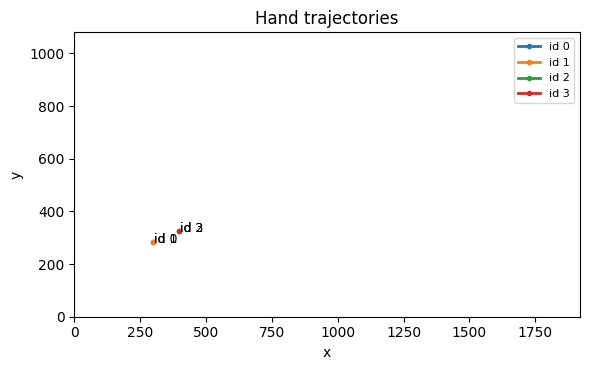

In [19]:
plot_trajectories({tid: t["points"] for tid, t in tracks.items()},
                  key="points", img_size=(1080, 1920))

In [21]:
import cv2
from collections import defaultdict, deque

def overlay_trajectories_on_video(
    video_path,
    tracks,
    out_path="trajectories.mp4",
    coords="pixels",           # "pixels" or "normalized" for (x,y) OR (x1,y1,x2,y2)
    tail=40,
    draw_ids=True,
    fps_override=None,
    key=None                   # e.g. "points" or "points_smooth" if tracks[tid] is a dict
):
    """
    Accepts per-track data in any of these forms:
      A) {tid: [(f, x, y), ...]}
      B) {tid: [(f, x, y, ...extra...), ...]}           # extra will be ignored
      C) {tid: [(f, x1, y1, x2, y2), ...]}              # will use box center
      D) {tid: {"points": [...], "points_smooth": [...]}} # set key="points_smooth" or "points"

    coords="normalized" means x,y (or box corners) are in [0,1] and will be scaled by (W,H).
    """

    def pick_sequence(seq_or_dict):
        if isinstance(seq_or_dict, dict):
            if key is None:
                # Prefer points_smooth if available
                if "points_smooth" in seq_or_dict:
                    return seq_or_dict["points_smooth"]
                elif "points" in seq_or_dict:
                    return seq_or_dict["points"]
                else:
                    raise ValueError("Track dict must contain 'points' or 'points_smooth'.")
            else:
                if key not in seq_or_dict:
                    raise ValueError(f"Requested key='{key}' not found in track dict.")
                return seq_or_dict[key]
        return seq_or_dict

    cap = cv2.VideoCapture(video_path)
    assert cap.isOpened(), f"Cannot open {video_path}"
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = fps_override or cap.get(cv2.CAP_PROP_FPS) or 30.0

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(out_path, fourcc, fps, (W, H))

    def to_xy(sample):
        """Return (f_idx, xi, yi) from a sample with variable length."""
        try:
            # Allow sequences and tuples; avoid dict samples
            if not hasattr(sample, "__len__") or isinstance(sample, dict):
                raise TypeError
            n = len(sample)
            if n < 3:
                raise ValueError(f"Sample too short (need at least 3): {sample}")

            f = int(round(sample[0]))
            if n >= 5:
                # Assume box: (f, x1, y1, x2, y2, [maybe score...])
                x1, y1, x2, y2 = float(sample[1]), float(sample[2]), float(sample[3]), float(sample[4])
                if coords == "normalized":
                    x1, x2 = x1 * W, x2 * W
                    y1, y2 = y1 * H, y2 * H
                x = 0.5 * (x1 + x2)
                y = 0.5 * (y1 + y2)
            else:
                # (f, x, y) possibly with an extra value as (f, x, y, score)
                x, y = float(sample[1]), float(sample[2])
                if coords == "normalized":
                    x, y = x * W, y * H

            return f, int(round(x)), int(round(y))
        except Exception as e:
            raise ValueError(f"Unrecognized sample format: {sample}") from e

    # Build per-frame map: frame -> {tid: (x, y)}
    by_frame = defaultdict(dict)
    for tid, seq in tracks.items():
        seq = pick_sequence(seq)
        for s in seq:
            f, xi, yi = to_xy(s)  # <-- previously where your ValueError happened
            by_frame[f][tid] = (xi, yi)

    # Rolling tails per track
    tails = defaultdict(lambda: deque(maxlen=tail))

    def color_for_id(i):
        seed = (i * 2654435761) & 0xFFFFFFFF
        return (seed & 255, (seed >> 8) & 255, (seed >> 16) & 255)  # BGR

    fidx = 0
    while True:
        ok, frame = cap.read()
        if not ok:
            break

        # update tails with points at this frame
        for tid, xy in by_frame.get(fidx, {}).items():
            tails[tid].append(xy)

        # draw tails + current point
        for tid, q in list(tails.items()):
            pts = list(q)
            for i in range(1, len(pts)):
                cv2.line(frame, pts[i-1], pts[i], color_for_id(tid), 2)
            if pts:
                cv2.circle(frame, pts[-1], 4, color_for_id(tid), -1)
                if draw_ids:
                    cv2.putText(frame, f"id {tid}", (pts[-1][0] + 6, pts[-1][1] - 6),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_for_id(tid), 2, cv2.LINE_AA)

        writer.write(frame)
        fidx += 1

    cap.release()
    writer.release()
    return out_path


In [22]:
# If your tracks dict looks like:
# tracks = {
#   0: [(0, 120, 160), (1, 140, 170), (2, 165, 180)],
#   1: [(0, 330, 150), (1, 325, 155)]
# }

out_path = overlay_trajectories_on_video(
    video_path="/Users/eddie/Downloads/videos/videos/P02_38.mp4",   # path to your source video
    tracks=tracks,            # dict of trajectories
    out_path="traj_overlay.mp4",
    coords="pixels",          # because x,y are already in pixel units
    tail=30                   # show last 30 points per trajectory
)

print("Overlay video saved to:", out_path)


Overlay video saved to: traj_overlay.mp4


In [1]:
import cv2
import numpy as np

def draw_bbox_safe(img, bbox, color=(0,255,0), thickness=2, title="bbox"):
    """
    Draw an axis-aligned bbox on img with lots of sanity checks.
    bbox can be (x, y, w, h) or (x1, y1, x2, y2) (auto-detected).
    Returns a copy with the box drawn. Also displays it (OpenCV with matplotlib fallback).
    """
    if img is None:
        raise ValueError("Image is None (failed to load).")
    if not hasattr(img, "shape") or img.size == 0:
        raise ValueError("Image is empty (size==0).")

    H, W = img.shape[:2]

    # ensure color image so the box is visible
    vis = img
    if img.ndim == 2:
        vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # ensure type is uint8 0..255
    if vis.dtype != np.uint8:
        vmin, vmax = float(vis.min()), float(vis.max())
        if vmax <= 1.0:  # likely 0..1 floats
            vis = np.clip(vis * 255.0, 0, 255).astype(np.uint8)
        else:
            vis = np.clip(vis, 0, 255).astype(np.uint8)

    bbox = np.array(bbox, dtype=float).ravel()
    if bbox.size != 4 or not np.isfinite(bbox).all():
        raise ValueError(f"Bad bbox: {bbox}")

    # auto-detect format: (x,y,w,h) vs (x1,y1,x2,y2)
    x, y, w, h = bbox
    if w > 0 and h > 0 and (x + w > x) and (y + h > y):
        x1, y1, x2, y2 = x, y, x + w, y + h
    else:
        # assume (x1,y1,x2,y2)
        x1, y1, x2, y2 = bbox
        # fix inverted corners if needed
        if x2 < x1: x1, x2 = x2, x1
        if y2 < y1: y1, y2 = y2, y1

    # clip to image bounds (and report if fully offscreen)
    if x2 < 0 or y2 < 0 or x1 >= W or y1 >= H:
        raise ValueError(f"BBox is fully outside image: {(x1,y1,x2,y2)} vs image size {(W,H)}")

    x1c = int(np.clip(round(x1), 0, W-1))
    y1c = int(np.clip(round(y1), 0, H-1))
    x2c = int(np.clip(round(x2), 0, W-1))
    y2c = int(np.clip(round(y2), 0, H-1))

    if x2c == x1c: x2c = min(x1c+1, W-1)
    if y2c == y1c: y2c = min(y1c+1, H-1)

    # scale thickness for big images
    t = max(thickness, int(round(0.003 * max(H, W))))
    cv2.rectangle(vis, (x1c, y1c), (x2c, y2c), color, t, lineType=cv2.LINE_AA)

    # corner dots help visibility
    r = max(3, int(round(0.006 * max(H, W))))
    for (px, py) in [(x1c,y1c),(x2c,y1c),(x2c,y2c),(x1c,y2c)]:
        cv2.circle(vis, (px,py), r, color, -1, lineType=cv2.LINE_AA)

    # show (with headless fallback)
    try:
        cv2.imshow(title, vis); cv2.waitKey(0); cv2.destroyAllWindows()
    except Exception:
        import matplotlib.pyplot as plt
        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.title(title); plt.show()

    return vis
img = cv2.imread("frame-1.png")
bbox =   (610.6235961914062, 387.4405822753906, 188.01824951171875, 268.1589050292969)
print(bbox)
out = draw_bbox_safe(img, bbox, color=(0,255,0), thickness=2, title="check bbox")


(610.6235961914062, 387.4405822753906, 188.01824951171875, 268.1589050292969)


In [5]:
import cv2
import numpy as np

def _prepare_vis(img):
    if img is None:
        raise ValueError("Image is None (failed to load).")
    if not hasattr(img, "shape") or img.size == 0:
        raise ValueError("Image is empty (size==0).")

    vis = img
    # ensure 3-channel BGR for visibility
    if vis.ndim == 2:
        vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)

    # ensure uint8 0..255
    if vis.dtype != np.uint8:
        vmin, vmax = float(vis.min()), float(vis.max())
        if vmax <= 1.0:
            vis = np.clip(vis * 255.0, 0, 255).astype(np.uint8)
        else:
            vis = np.clip(vis, 0, 255).astype(np.uint8)
    return vis

def _to_xyxy(bbox):
    b = np.array(bbox, dtype=float).ravel()
    if b.size != 4 or not np.isfinite(b).all():
        raise ValueError(f"Bad bbox: {bbox}")
    x, y, w, h = b
    if w > 0 and h > 0 and (x + w > x) and (y + h > y):
        x1, y1, x2, y2 = x, y, x + w, y + h
    else:
        x1, y1, x2, y2 = b
        if x2 < x1: x1, x2 = x2, x1
        if y2 < y1: y1, y2 = y2, y1
    return x1, y1, x2, y2

def _clip_box(x1, y1, x2, y2, W, H):
    if x2 < 0 or y2 < 0 or x1 >= W or y1 >= H:
        return None  # fully offscreen
    x1c = int(np.clip(round(x1), 0, W - 1))
    y1c = int(np.clip(round(y1), 0, H - 1))
    x2c = int(np.clip(round(x2), 0, W - 1))
    y2c = int(np.clip(round(y2), 0, H - 1))
    if x2c == x1c: x2c = min(x1c + 1, W - 1)
    if y2c == y1c: y2c = min(y1c + 1, H - 1)
    return x1c, y1c, x2c, y2c

def draw_bboxes_safe_cv2(
    img,
    bboxes,
    colors=None,           # None -> auto palette, (B,G,R) tuple for all, or list per box
    thickness=2,
    labels=None,           # optional list of strings
    alpha=0.25,            # 0..1 translucent fill per box
    title="bboxes"
):
    """
    Draw multiple axis-aligned bboxes on img with safety checks (OpenCV).
    - bboxes: iterable of boxes, each (x,y,w,h) or (x1,y1,x2,y2)
    Returns a copy with boxes drawn. Also displays it (OpenCV with matplotlib fallback).
    """
    vis = _prepare_vis(img)
    H, W = vis.shape[:2]
    out = vis.copy()

    # scale-dependent sizes
    t = max(thickness, int(round(0.003 * max(H, W))))
    r = max(3, int(round(0.006 * max(H, W))))

    # color handling (BGR)
    auto_palette = [
        (0,255,0), (0,0,255), (255,128,0),
        (255,0,255), (255,0,0), (255,255,0),
        (255,0,127), (255,128,255), (0,255,255)
    ]
    if colors is None:
        color_list = [auto_palette[i % len(auto_palette)] for i in range(len(bboxes))]
    elif isinstance(colors, (list, tuple)) and len(colors) == 3 and not isinstance(colors[0], (list, tuple)):
        color_list = [tuple(map(int, colors))] * len(bboxes)
    else:
        if len(colors) != len(bboxes):
            raise ValueError("colors must be None, a single (B,G,R) tuple, or a list matching bboxes length")
        color_list = [tuple(map(int, c)) for c in colors]

    if labels is not None and len(labels) != len(bboxes):
        raise ValueError("labels length must match bboxes length")

    overlay = out.copy()  # for translucent fills
    any_visible = False

    # First pass: draw fills to overlay
    if alpha and alpha > 0:
        a = float(np.clip(alpha, 0.0, 1.0))
        for i, box in enumerate(bboxes):
            x1, y1, x2, y2 = _to_xyxy(box)
            clipped = _clip_box(x1, y1, x2, y2, W, H)
            if clipped is None:
                continue
            any_visible = True
            x1c, y1c, x2c, y2c = clipped
            cv2.rectangle(overlay, (x1c, y1c), (x2c, y2c), color_list[i], -1)
        # blend fills
        out = cv2.addWeighted(overlay, a, out, 1 - a, 0)

    # Second pass: outlines, corner dots, labels (on blended image)
    for i, box in enumerate(bboxes):
        x1, y1, x2, y2 = _to_xyxy(box)
        clipped = _clip_box(x1, y1, x2, y2, W, H)
        if clipped is None:
            continue
        any_visible = True
        x1c, y1c, x2c, y2c = clipped
        color = color_list[i]

        # outline
        cv2.rectangle(out, (x1c, y1c), (x2c, y2c), color, t, lineType=cv2.LINE_AA)

        # corner dots
        for (px, py) in [(x1c,y1c),(x2c,y1c),(x2c,y2c),(x1c,y2c)]:
            cv2.circle(out, (px,py), r, color, -1, lineType=cv2.LINE_AA)

        # optional label (solid background for legibility)
        if labels is not None and labels[i]:
            txt = str(labels[i])
            font = cv2.FONT_HERSHEY_SIMPLEX
            fs = max(0.4, 0.8 * t / 2.0)  # scale a bit with thickness
            (tw, th), baseline = cv2.getTextSize(txt, font, fs, max(1, t//2))
            pad = max(2, t)
            x2_label = min(W - 1, x1c + tw + 2 * pad)
            y2_label = min(H - 1, y1c + th + 2 * pad)
            cv2.rectangle(out, (x1c, y1c), (x2_label, y2_label), color, -1)
            cv2.putText(out, txt, (x1c + pad, y1c + th + pad//2),
                        font, fs, (255,255,255), max(1, t//2), cv2.LINE_AA)

    if not any_visible:
        raise ValueError("All bboxes are fully outside the image bounds.")

    # show (with headless fallback)
    try:
        cv2.imshow(title, out); cv2.waitKey(0); cv2.destroyAllWindows()
    except Exception:
        try:
            import matplotlib.pyplot as plt
            plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
            plt.axis("off"); plt.title(title); plt.show()
        except Exception:
            pass

    return out

# ---- example usage ----
if __name__ == "__main__":
    import cv2
    img = cv2.imread("frame-1.png")

    bboxes = [(609.03955078125, 385.3572082519531, 187.055908203125, 267.8467102050781), (608.9849243164062, 385.8311462402344, 187.31744384765625, 267.8127136230469), (609.44384765625, 386.01092529296875, 187.2750244140625, 267.89337158203125), (609.6187744140625, 386.58831787109375, 187.37518310546875, 267.443115234375), (609.8786010742188, 386.7287292480469, 187.63873291015625, 267.8406066894531), (609.8786010742188, 386.7287292480469, 187.63873291015625, 267.8406066894531), (609.7284545898438, 386.6197814941406, 188.2479248046875, 267.7710266113281), (610.2693481445312, 387.42864990234375, 187.87335205078125, 268.02313232421875), (609.9044189453125, 387.26226806640625, 188.2152099609375, 268.2691650390625), (610.6235961914062, 387.4405822753906, 188.01824951171875, 268.1589050292969)]

    # labels = ["person", "proposal A", "face?", "big box"]

    out = draw_bboxes_safe_cv2(
        img,
        bboxes=bboxes,
        colors=None,           # auto palette
        thickness=2,
        # labels=labels,
        alpha=0.25,
        title="multiple bboxes (cv2)"
    )
    # cv2.imwrite("bboxes_overlay.png", out)
